## STEP 1: PRE-PROCESSING

📌 Importing necessary libraries

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import random
from protree.explainers import G_KM
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

shap.initjs()

c:\Users\rober\Desktop\sem5\dupa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📌 Our initial step is to assess the structure of the dataset. We begin by checking for any null values and proceed by selecting 10 features that are potentially significant for our analysis. Following this, we apply k-bins discretization and perform one-hot encoding.

In [2]:
df = pd.read_csv('EmployeeData.csv')
df.head() 

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [4]:
df_selected = df[["Age", "Attrition", "BusinessTravel", 
                  "DailyRate", "Department", "DistanceFromHome", 
                  "Education", "EducationField", "Gender", 
                  "YearsSinceLastPromotion"]]

In [5]:
df_selected.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,Gender,YearsSinceLastPromotion
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,Female,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,Male,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,Male,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,Female,3
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,Male,2


In [6]:
df_selected.describe()

,Age,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.187755
std,9.135373,403.509100,8.106864,1.024165,3.222430
min,18.000000,102.000000,1.000000,1.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,1.000000
75%,43.000000,1157.000000,14.000000,4.000000,3.000000
max,60.000000,1499.000000,29.000000,5.000000,15.000000


In [7]:
age_bins = [df_selected['Age'].min(),30, 45, df_selected['Age'].max()]
age_labels = ["Junior", 'Medium', 'Senior']

df_selected.loc[:, 'AgeGroup'] = pd.cut(df_selected["Age"], bins = age_bins, labels = age_labels, right=False)

df_selected = df_selected.drop('Age', axis = 1)

df_selected.head()

C:\Users\rober\AppData\Local\Temp\ipykernel_23516\487389706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.loc[:, 'AgeGroup'] = pd.cut(df_selected["Age"], bins = age_bins, labels = age_labels, right=False)


,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,Gender,YearsSinceLastPromotion,AgeGroup
0,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,Female,0,Medium
1,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,Male,1,Senior
2,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,Male,0,Medium
3,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,Female,3,Medium
4,No,Travel_Rarely,591,Research & Development,2,1,Medical,Male,2,Junior


In [8]:
df_encoded = pd.get_dummies(df_selected)
df_encoded.head()

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,...,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,AgeGroup_Junior,AgeGroup_Medium,AgeGroup_Senior
0,1102,1,2,0,False,True,False,False,True,False,...,True,False,False,False,False,True,False,False,True,False
1,279,8,1,1,True,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,True
2,1373,2,2,0,False,True,False,False,True,False,...,False,False,False,True,False,False,True,False,True,False
3,1392,3,4,3,True,False,False,True,False,False,...,True,False,False,False,False,True,False,False,True,False
4,591,2,1,2,True,False,False,False,True,False,...,False,False,True,False,False,False,True,True,False,False


In [9]:
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'bool':
        df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.dtypes)

DailyRate                            int64
DistanceFromHome                     int64
Education                            int64
YearsSinceLastPromotion              int64
Attrition_No                         int32
Attrition_Yes                        int32
BusinessTravel_Non-Travel            int32
BusinessTravel_Travel_Frequently     int32
BusinessTravel_Travel_Rarely         int32
Department_Human Resources           int32
Department_Research & Development    int32
Department_Sales                     int32
EducationField_Human Resources       int32
EducationField_Life Sciences         int32
EducationField_Marketing             int32
EducationField_Medical               int32
EducationField_Other                 int32
EducationField_Technical Degree      int32
Gender_Female                        int32
Gender_Male                          int32
AgeGroup_Junior                      int32
AgeGroup_Medium                      int32
AgeGroup_Senior                      int32
dtype: obje

In [10]:
df_encoded.head()

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,...,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,AgeGroup_Junior,AgeGroup_Medium,AgeGroup_Senior
0,1102,1,2,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0
1,279,8,1,1,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
2,1373,2,2,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,1,0
3,1392,3,4,3,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
4,591,2,1,2,1,0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0


## STEP 2: CREATING A MODEL

📌 We begin by splitting the dataset into training (70%) and testing (30%) sets. Next, we build two models: an XGBoost Classifier and a Random Forest Classifier. After training the models, we evaluate and compare their accuracy and start to understanding these models

In [11]:
# XGBoost Classifier

X_XGBoost = df_encoded.drop(['Attrition_Yes','Attrition_No'], axis = 1)
y_XGBoost = df_encoded['Attrition_Yes']

X_train, X_test, y_train, y_test = train_test_split(X_XGBoost, y_XGBoost, test_size=0.3, random_state=42)

model_XGBoost = XGBClassifier(random_state=42).fit(X_train, y_train)

y_pred = model_XGBoost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy:.4f}')

XGBoost Accuracy: 0.8118


In [12]:
#Random Forest Classifier

X_RFClassifier= df_encoded.drop(['Attrition_Yes','Attrition_No'], axis = 1)
y_RFClassifier = df_encoded['Attrition_Yes']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_RFClassifier, y_RFClassifier, test_size=0.3, random_state=42)

model_y_RFClassifier = RandomForestClassifier(random_state=42).fit(X_train_2, y_train_2)

y_pred = model_y_RFClassifier.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

Random Forest Accuracy: 0.8390


## STEP 2: FIRST EXPLANATORY METHOD
📌We will incorporate **SHAP (SHapley Additive exPlanations)** to analyze feature importance in our model. SHAP values provide a detailed understanding of how each feature influences the model's individual predictions. 

For a single prediction, we can visualize the feature contributions using either a **waterfall chart** or a **force plot**. These plots will highlight the most influential features, offering clear and interpretable insights into how the model arrived at its decision. This approach enhances transparency and allows us to better interpret complex machine learning models.


📌 **WATERFALL PLOT** For binary classification task, our chart looks as follows:
- Y-axis shows top 10 most important features, which influenced the most to the prediction. There are names of features and on the left is thr value for our inctance
- X-axis shows the calculated values and the E[f(x)] is the average predicted log odds across all instances
- Gray vertical line with f(x) is the predicted log odds of probability P of concrete row which can be calculated by

$$ f(x) = \ln( \frac{P}{1-P})$$

- These red and blue bars show how the feature contributes to f(x). 

Red bars have a positive contribution to the prediction, so our model is more likely to choose the positive class (1). The blue bars, on the other hand, have a negative contribution, making the prediction more inclined towards class 0.


In [13]:
# XGBoost Classifier with SHAP

explainer = shap.Explainer(model_XGBoost, X_test)
shap_values = explainer(X_test)

In [14]:
# Choosing random instances from our test set

random.seed(55)
rows_to_check = random.sample(range(len(X_test)+1), 3)
# print(rows_to_check)
single_rows_predictions = model_XGBoost.predict(X_test.iloc[rows_to_check]) 
print(f'''Prediction for our instances:
    for {rows_to_check[0]} row the prediction is: {single_rows_predictions[0]}
    for {rows_to_check[1]} row the prediction is: {single_rows_predictions[1]}
    for {rows_to_check[2]} row the prediction is: {single_rows_predictions[2]}''')

Prediction for our instances:
    for 46 row the prediction is: 1
    for 100 row the prediction is: 0
    for 76 row the prediction is: 1


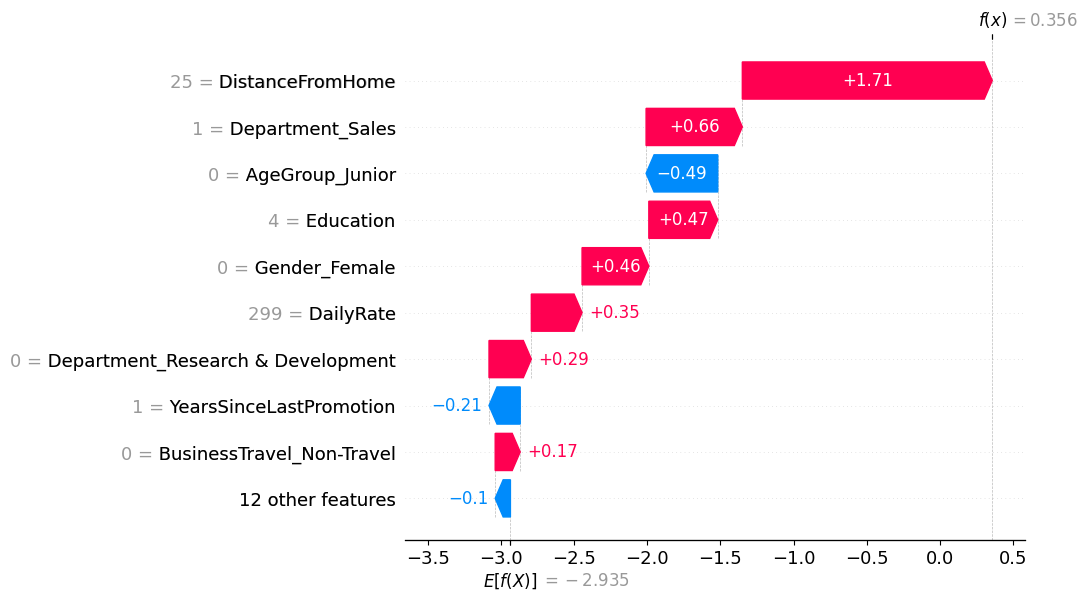

Predicted class probabilities for instance 46: [[0.4118656 0.5881344]]


In [15]:
# 1. Creating the waterfall for first choosen instance 
shap.waterfall_plot(shap_values[rows_to_check[0]])

# 2. Provide calculations to proof the values on the plot
instance_idx = rows_to_check[0]
probabilities = model_XGBoost.predict_proba(X_test[instance_idx:instance_idx+1])
print(f"Predicted class probabilities for instance {instance_idx}: {probabilities}")

### 📉 A detailed description of a plot 
#### 1. First we will provide calculations.
The probabilty equals **P=0.412** so we can calcualte f(x)

$$ f(x) = \ln( \frac{0.412}{1-0.412})$$
$$ f(x) = \ln( \frac{0.412}{0.588})$$
$$ f(x) = \ln( 0.70068)$$
$$ f(x) = -0.3557$$

We can see that on the gray vertical line we have the same result, therfore mathematical proof is done

#### 2. In this analysis, we examine the specific features that influence the prediction for the given instance.

It is clear that **DistanceFromHome** has the greatest impact on the prediction, as it increases the log odds of the positive class (attrition) by 1.71. This suggests that employees who work farther from home are more likely to leave the company. The second most influential feature is **Department_Sales**, which also positively contributes to the likelihood of the employee leaving the company, increasing the probability of class 1 (attrition).

Conversely, two features appear to reduce the probability of employee attrition. These are **AgeGroup_Junior** and **YearsSinceLastPromotion**. Employees categorized as juniors (age between 18 and 30 years) and those who received a promotion within the last year are less likely to leave the company.

#### <u>Conclusion</u>
In summary, the analysis of this plot suggests that employees between the ages of 18 and 30, who have received a promotion within the last year, are less likely to attrite. In contrast, employees who live far from home and work in the Sales department are more likely to leave the company.

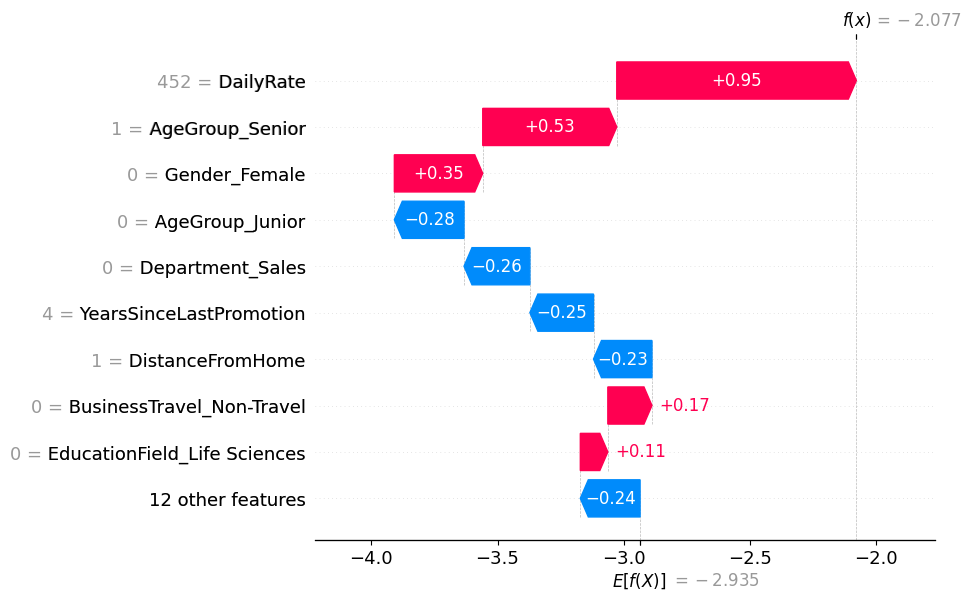

In [16]:
shap.waterfall_plot(shap_values[rows_to_check[1]])

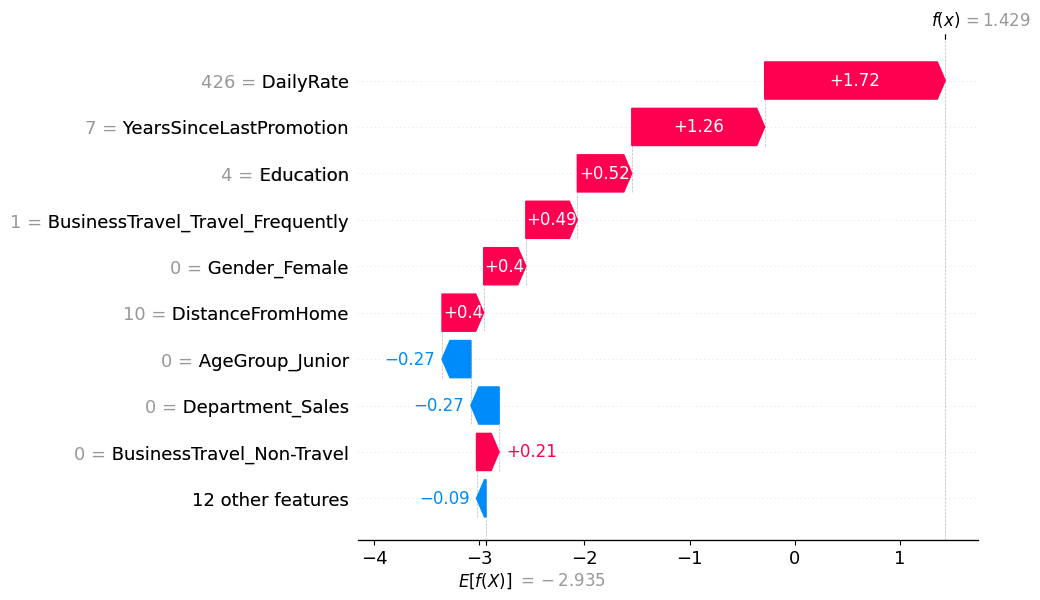

In [17]:
shap.waterfall_plot(shap_values[rows_to_check[2]])

📉 Summrazing all these three plots we can conclude that most likely features that lead to attrition or not.

| Feature                |    Value   |  Attrite |   Explanation |
|------------------------|------------|----------|---------------|
| DistanceFromHome       | 10 and 26  | YES      | Employees who work far from home may experience longer commutes, whether by car or train. The inconvenience of travel, including ticket costs or fuel expenses, can lead to higher attrition.|
| Department_Sales       | YES        | YES      | Working in sales can be stressful, and some employees may struggle to cope with the high demands of the job, leading to higher turnover in this sector.|
| AgeGroup_Junior        | NO         |   NO     | Younger employees, especially those new to the workforce, tend to focus on gaining experience and building their careers, making them less likely to leave the company at this stage.|
| YearsSinceLastPromotion| 1 and 4    | NO       | Employees who received a promotion in the past year may feel optimistic about their future prospects, which could discourage them from leaving in the short term.|
| Gender_Female          | NO         |  YES     |Female employees may have different motivations for staying in or leaving a job. For some, factors like family responsibilities or pregnancy could make work stability more important.|
| Education              | 4          | YES      | Employees with higher education levels often seek new challenges and opportunities for advancement, increasing their likelihood of attrition if they don't see growth within the organization.|
|BusinessTravel_Non-Travel|  0       | YES      | Employees who do not travel may seek new opportunities that offer the chance to explore new places or gain diverse experiences, increasing their likelihood of leaving.|
|DailyRate              | 452 and 426| YES | High daily rates may be linked with higher job satisfaction.|
|AgeGroup_Senior|    YES |  YES | Senior employees nearing retirement or considering retirement may be more likely to leave the company, as they prepare for the next phase of life.|
| DistanceFromHome       | 1 | NO     | A short commute reduces travel time and cost, which can make the job more attractive and lower the likelihood of attrition.|




📌 **FORCE PLOT**  helps explain the prediction of a machine learning model for an individual instance. It visually breaks down how different features contribute to the final prediction and why a certain class is predicted over others.

The SHAP Force Plot is quite similar to the Waterfall Plot, but it presents all the information on a single line. 

As we will observe, it contains the same values and displays identical features with corresponding contributions to the model's prediction f(x).

Therefore, there is no need to reiterate the same summary. Instead, we can explore the possibility of generating a Force Plot that compares multiple instances simultaneously.

In [18]:
# plot only for 1 instance
shap.plots.force(shap_values[rows_to_check[0]])

It is interactive plot, so can try to find any correlation between features and their effect on prediction. 
Now we will take 100 instances and draw them all on one plot. 

The features that we will take into account are **YearsSinceLastPromotion** and **DistanceFromHome**

In [19]:
#plot for more instances
shap.plots.force(shap_values[1:100])

In [20]:
shap.plots.force(shap_values[1:100])

📉 From these two plots, we can identify the following patterns:

1. Employees with a gap of 3-5 years, or more than 9 years, since their last promotion are less likely to attrite.
2. Employees who commute between 8 and 25 miles from home are more likely to leave the company.

## STEP 3: SECOND EXPLANATORY METHOD
📌 In this section we will focus on **Prototype Explanations** which are a powerful and intuitive way to explain machine learning model predictions. These explanations focus on identifying prototypes—instances in the training data that are "representative" of specific predictions made by the model.

-One popular method to achieve prototype explanations is **A-PETE (Adaptive Prototype Explanations of Tree Ensembles)**, which can be combined with various machine learning models, including **Random Forests**. Let’s explore the key concepts and process of generating prototype-based explanations for tabular data using Random Forest and A-PETE.

1. **<u>Prototype Explanations</u>** identify the most representative examples (prototypes) from the training data that help explain why a given prediction was made by the model. Instead of relying solely on individual feature importance, prototypes offer a more intuitive approach. These prototype instances can be thought of as "typical" examples that the model has learned from, and they help humans understand the model's decision by providing concrete, understandable examples.

2.  **<u>A-PETE</u>** stands for **Adaptive Prototype Explanations of Tree Ensembles**. It is a prototype selction method for ensemble of the tree classifiers which automise selection of prototypes for classifier. An important thing is that A-PETE provides sufficient number of prototypes for interpreting the model. In this approach is used:
- specialised distance measure
- modified k-medoid approach


3. **<u>Random Forest</u>** is an ensemble model made up of many decision trees and tis is highly effective for tabular data. When explaining Random Forest predictions, A-PETE can be particularly useful because Random Forests provide robust, interpretable models, but explaining the decisions of an ensemble of trees can be complex. By using A-PETE, we can focus on identifying prototypes that the Random Forest model is "most influenced" by in making a prediction.

In [21]:
count_yes = df_encoded[df_encoded['Attrition_Yes'] == 1].shape[0]

print(f'Liczba danych z Attrition_Yes = "Yes": {count_yes}')

Liczba danych z Attrition_Yes = "Yes": 237


In [22]:
count_no = df_encoded[df_encoded['Attrition_Yes'] == 0].shape[0]

print(f'Liczba danych z Attrition_Yes = "No": {count_no}')

Liczba danych z Attrition_Yes = "No": 1233


It is important to notice that columns are inbalanced, which may hava a big impact on our data. Before balancing data it was difficult for us to use APete properly - instead of two prototypes there was only one (we suggest that is because of small diversity in the data or other parameters of the algorithm.) We used dwonsampling method, to balance data. It helped.

In [23]:
df_majority = df_encoded[df_encoded['Attrition_Yes'] == 0]
df_minority = df_encoded[df_encoded['Attrition_Yes'] == 1]


df_majority_downsampled = resample(df_majority, 
                                     replace=False, 
                                     n_samples=len(df_minority), 
                                     random_state=42) 

df_balanced = pd.concat([df_majority_downsampled, df_minority])

X_balanced = df_balanced.drop(['Attrition_Yes','Attrition_No'], axis = 1)
y_balanced = df_balanced['Attrition_Yes']

X_balanced.head()


,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,...,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,AgeGroup_Junior,AgeGroup_Medium,AgeGroup_Senior
418,1349,23,3,0,0,0,1,0,1,0,...,1,0,0,0,0,1,0,1,0,0
643,1265,3,3,1,0,0,1,0,1,0,...,1,0,0,0,0,1,0,0,1,0
963,1009,2,2,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
62,989,7,2,13,0,0,1,0,1,0,...,0,0,1,0,0,1,0,0,0,1
1165,602,1,5,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [24]:
random_forest = RandomForestClassifier().fit(X_balanced, y_balanced)
explainer = G_KM(model = random_forest, n_prototypes = 5)
prototypes = explainer.select_prototypes(X_balanced)
print(prototypes)

{0:       DailyRate  DistanceFromHome  Education  YearsSinceLastPromotion  \
1095        589                28          4                        5   
868        1179                19          4                        3   
750        1448                28          3                       11   
753         945                22          3                        2   
808        1107                28          4                        1   

      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1095                          0                                 0   
868                           0                                 0   
750                           0                                 0   
753                           0                                 1   
808                           0                                 0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
1095                             1                           0   
868       

In [25]:
for key, prototype in prototypes.items():
    print(f"Prototype {key}:")
    print(prototype.head()) 

Prototype 0:
      DailyRate  DistanceFromHome  Education  YearsSinceLastPromotion  \
1095        589                28          4                        5   
868        1179                19          4                        3   
750        1448                28          3                       11   
753         945                22          3                        2   
808        1107                28          4                        1   

      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1095                          0                                 0   
868                           0                                 0   
750                           0                                 0   
753                           0                                 1   
808                           0                                 0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
1095                             1                           0   
8

In [26]:
# List for storing rows
from copy import deepcopy

prototype_list = []
num_of_rows = 0

for key, prototype in prototypes.items():
    print(f"Prototype {key}:")
    print(prototype.head())

    num_of_rows += len(prototype)
    # Adding a column, so we know which class it is
    prototype_copy = deepcopy(prototype)
    prototype_copy['Class'] = key

    # Appending to the list
    # prototype_list.append(prototype)
    prototype_list.append(prototype_copy)

prototypes_df = pd.concat(prototype_list, ignore_index=True)
prototypes_df.head(num_of_rows)

Prototype 0:
      DailyRate  DistanceFromHome  Education  YearsSinceLastPromotion  \
1095        589                28          4                        5   
868        1179                19          4                        3   
750        1448                28          3                       11   
753         945                22          3                        2   
808        1107                28          4                        1   

      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1095                          0                                 0   
868                           0                                 0   
750                           0                                 0   
753                           0                                 1   
808                           0                                 0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
1095                             1                           0   
8

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,...,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,AgeGroup_Junior,AgeGroup_Medium,AgeGroup_Senior,Class
0,589,28,4,5,0,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,1179,19,4,3,0,0,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
2,1448,28,3,11,0,0,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,945,22,3,2,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,1107,28,4,1,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
5,827,29,4,3,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
6,1357,25,3,0,0,0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,1
7,1456,13,5,2,0,0,1,0,0,1,...,1,0,0,0,0,1,0,1,0,1
8,1287,7,3,1,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1
9,1475,13,2,2,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,1


In [27]:
prototype_0 = prototypes[0]
print(prototype_0)

      DailyRate  DistanceFromHome  Education  YearsSinceLastPromotion  \
1095        589                28          4                        5   
868        1179                19          4                        3   
750        1448                28          3                       11   
753         945                22          3                        2   
808        1107                28          4                        1   

      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1095                          0                                 0   
868                           0                                 0   
750                           0                                 0   
753                           0                                 1   
808                           0                                 0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
1095                             1                           0   
868           

## DECODING

In [28]:
# making a datframe from prototype

prototype_list = []
num_of_rows = 0

for key, prototype in prototypes.items():
    print(f"Prototype {key}:")
    print(prototype.head())

    num_of_rows += len(prototype)
    # Adding a column, so we know which class it is
    prototype_copy = deepcopy(prototype)
    prototype_copy['Class'] = key
    prototype_list.append(prototype_copy)

prototypes_df = pd.concat(prototype_list, ignore_index=True)
prototypes_df.head(num_of_rows)
prototypes_df.columns


Prototype 0:
      DailyRate  DistanceFromHome  Education  YearsSinceLastPromotion  \
1095        589                28          4                        5   
868        1179                19          4                        3   
750        1448                28          3                       11   
753         945                22          3                        2   
808        1107                28          4                        1   

      BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1095                          0                                 0   
868                           0                                 0   
750                           0                                 0   
753                           0                                 1   
808                           0                                 0   

      BusinessTravel_Travel_Rarely  Department_Human Resources  \
1095                             1                           0   
8

Index(['DailyRate', 'DistanceFromHome', 'Education', 'YearsSinceLastPromotion',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'AgeGroup_Junior', 'AgeGroup_Medium',
       'AgeGroup_Senior', 'Class'],
      dtype='object')

In [29]:
# DECODING

# list of categories to delete
categories_1 = ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently','BusinessTravel_Travel_Rarely']
categories_2 = ['Department_Human Resources', 'Department_Research & Development', 'Department_Sales']
categories_3 = ['EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree']
categories_4 = ['Gender_Female', 'Gender_Male']
categories_5 = ['AgeGroup_Junior', 'AgeGroup_Medium','AgeGroup_Senior']


def remove_words(main_word, words_to_remove):
    for word in words_to_remove:
        main_word = main_word.replace(word, '')
    return main_word


def decode_one_hot(df, category_columns):
    decoded_labels = []
    for _, row in df[category_columns].iterrows():
        index = row.idxmax()  # Get the column name with the max value (1)
        decoded_labels.append(remove_words(index, ['BusinessTravel_','Department_','EducationField_', 'Gender_','AgeGroup_']))  
    return decoded_labels

# Decoding the specified columns
prototypes_df['BusinessTravel'] = decode_one_hot(prototypes_df, categories_1)
prototypes_df['Department'] = decode_one_hot(prototypes_df, categories_2)
prototypes_df['EducationField'] = decode_one_hot(prototypes_df, categories_3)
prototypes_df['Gender'] = decode_one_hot(prototypes_df, categories_4)
prototypes_df['AgeGroup'] = decode_one_hot(prototypes_df, categories_5)

# Droping rest columns
prototypes_df =prototypes_df.drop(columns=categories_1+categories_2+categories_3+categories_4+categories_5)

prototypes_df.head(6)

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,Class,BusinessTravel,Department,EducationField,Gender,AgeGroup
0,589,28,4,5,0,Travel_Rarely,Research & Development,Life Sciences,Male,Medium
1,1179,19,4,3,0,Travel_Rarely,Research & Development,Medical,Male,Junior
2,1448,28,3,11,0,Travel_Rarely,Sales,Medical,Female,Medium
3,945,22,3,2,0,Travel_Frequently,Research & Development,Medical,Female,Medium
4,1107,28,4,1,0,Travel_Rarely,Research & Development,Life Sciences,Female,Junior
5,827,29,4,3,1,Travel_Frequently,Research & Development,Medical,Female,Medium


In [30]:
X_balanced_df = deepcopy(X_balanced) 


X_balanced_df['BusinessTravel'] = decode_one_hot(X_balanced_df, categories_1)
X_balanced_df['Department'] = decode_one_hot(X_balanced_df, categories_2)
X_balanced_df['EducationField'] = decode_one_hot(X_balanced_df, categories_3)
X_balanced_df['Gender'] = decode_one_hot(X_balanced_df, categories_4)
X_balanced_df['AgeGroup'] = decode_one_hot(X_balanced_df, categories_5)


X_balanced_df = X_balanced_df.drop(columns=categories_1+categories_2+categories_3+categories_4+categories_5)


X_balanced_df.head(6)


,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
418,1349,23,3,0,Travel_Rarely,Research & Development,Life Sciences,Female,Junior
643,1265,3,3,1,Travel_Rarely,Research & Development,Life Sciences,Female,Medium
963,1009,2,2,1,Travel_Rarely,Sales,Life Sciences,Female,Medium
62,989,7,2,13,Travel_Rarely,Research & Development,Medical,Female,Senior
1165,602,1,5,0,Travel_Frequently,Human Resources,Human Resources,Male,Medium
1370,1169,14,4,1,Non-Travel,Research & Development,Technical Degree,Male,Senior


To sum things up:
sometimes it is difficult to read raw data, so we present some plots which will help us understand the meaning of the prototypes.

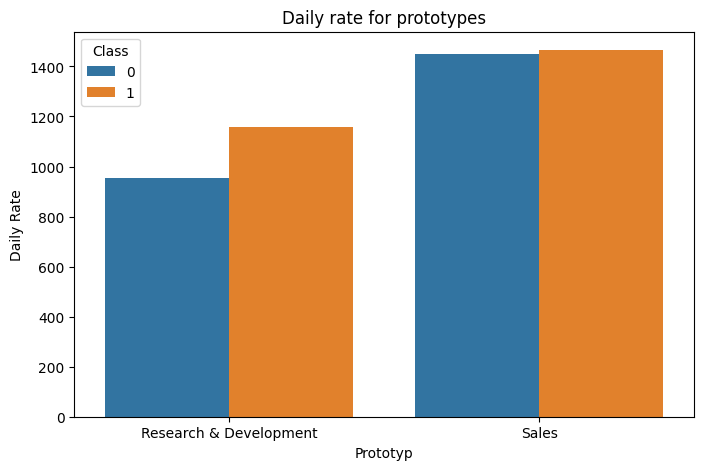

In [31]:
# Making smaller dataframe
avg_daily_rate = prototypes_df.groupby(['Department', 'Class'])['DailyRate'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='Department', y='DailyRate', data=avg_daily_rate,  hue='Class')
plt.title('Daily rate for prototypes')
plt.xlabel('Prototyp')
plt.ylabel('Daily Rate')
plt.show()

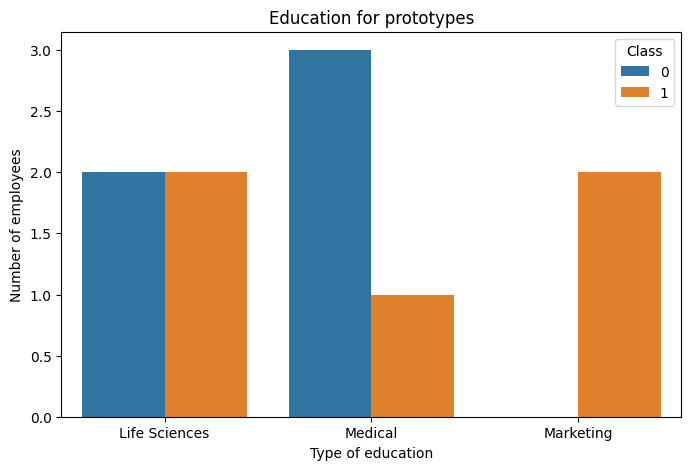

In [32]:
last_promotion = prototypes_df[['EducationField', 'Class']]

plt.figure(figsize=(8, 5))
sns.countplot(x='EducationField', hue='Class', data=last_promotion)
plt.title('Education for prototypes')
plt.xlabel('Type of education')
plt.ylabel('Number of employees')
plt.show()

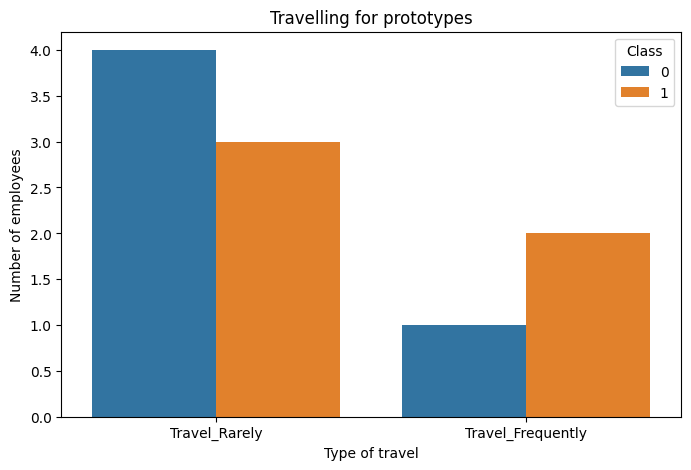

In [33]:
business_travel = prototypes_df[['BusinessTravel', 'Class']]

plt.figure(figsize=(8, 5))
sns.countplot(x='BusinessTravel', hue='Class', data=business_travel)
plt.title('Travelling for prototypes')
plt.xlabel('Type of travel')
plt.ylabel('Number of employees')
plt.show()

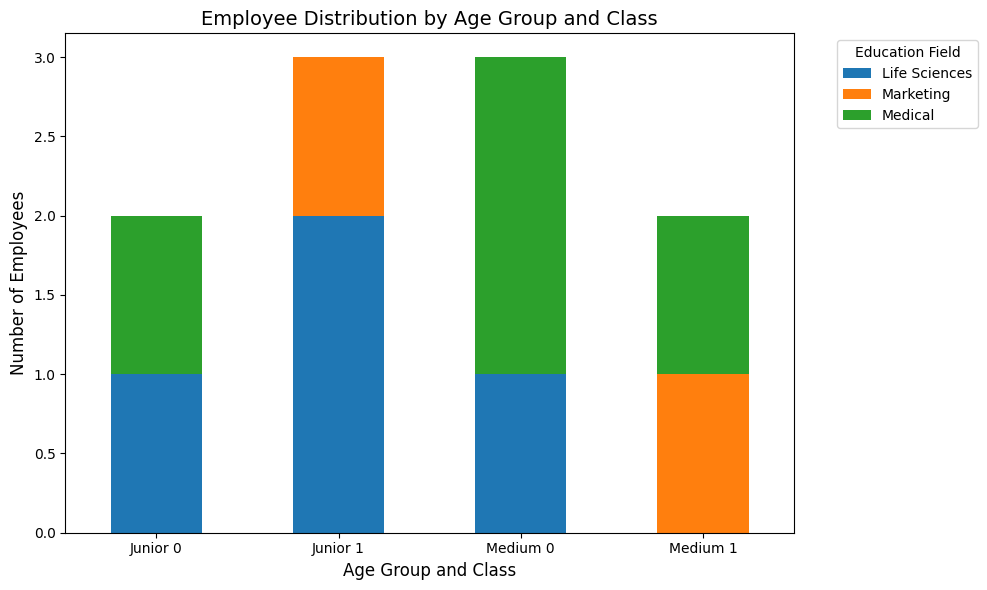

In [34]:
relation_between_age_group_and_education = prototypes_df[['AgeGroup', 'Class', 'EducationField']]

# Plotting
# Create a new column for combined AgeGroup and Class
prototypes_df['AgeClass'] = prototypes_df['AgeGroup'] + ' ' + prototypes_df['Class'].astype(str)

# Creating a cross-tabulation
cross_tab = pd.crosstab(prototypes_df['AgeClass'], prototypes_df['EducationField'])

# Plotting the cross-tabulated data
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Employee Distribution by Age Group and Class', fontsize=14)
plt.xlabel('Age Group and Class', fontsize=12)
plt.ylabel('Number of Employees', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Education Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [72]:
# find alike prototype for a specific instance (negative class)
# best fitted
x_0, y_0 = X_balanced.values[0].reshape(1, -1), y_balanced.values[0]  ## negative class 0
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

0
Max similarity:  0.23
DailyRate                            1107
DistanceFromHome                       28
Education                               4
YearsSinceLastPromotion                 1
BusinessTravel_Non-Travel               0
BusinessTravel_Travel_Frequently        0
BusinessTravel_Travel_Rarely            1
Department_Human Resources              0
Department_Research & Development       1
Department_Sales                        0
EducationField_Human Resources          0
EducationField_Life Sciences            1
EducationField_Marketing                0
EducationField_Medical                  0
EducationField_Other                    0
EducationField_Technical Degree         0
Gender_Female                           1
Gender_Male                             0
AgeGroup_Junior                         1
AgeGroup_Medium                         0
AgeGroup_Senior                         0
Name: 808, dtype: int64


In [73]:
X = X_balanced_df.iloc[[0]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['DailyRate']
matching_index = prototypes_df[prototypes_df['DailyRate'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class', 'AgeClass'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
INSTANCE,1349,23,3,0,Travel_Rarely,Research & Development,Life Sciences,Female,Junior
PROTOTYPE,1107,28,4,1,Travel_Rarely,Research & Development,Life Sciences,Female,Junior


In [74]:
# Dodanie indeksu jako pierwszej kolumny
combined_df_with_index = combined_df.reset_index()

# Tworzenie tabeli
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
ax.table(
    cellText=combined_df_with_index.values,
    colLabels=combined_df_with_index.columns,  # Uwzględnia kolumnę indeksu
    cellLoc='center',
    loc='center'
)

# Zapis obrazu
plt.savefig("combined_1.jpg", format='jpg', bbox_inches='tight', dpi=600)
plt.close()


In [75]:
# find alike prototype for a specific instance (positive class)
# best fitted

x_0, y_0 = X_balanced.values[300].reshape(1, -1), y_balanced.values[300]  ## positive class 1
max_similarity = 0  
print(y_0)
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

1
Max similarity:  0.01
DailyRate                            827
DistanceFromHome                      29
Education                              4
YearsSinceLastPromotion                3
BusinessTravel_Non-Travel              0
BusinessTravel_Travel_Frequently       1
BusinessTravel_Travel_Rarely           0
Department_Human Resources             0
Department_Research & Development      1
Department_Sales                       0
EducationField_Human Resources         0
EducationField_Life Sciences           0
EducationField_Marketing               0
EducationField_Medical                 1
EducationField_Other                   0
EducationField_Technical Degree        0
Gender_Female                          1
Gender_Male                            0
AgeGroup_Junior                        0
AgeGroup_Medium                        1
AgeGroup_Senior                        0
Name: 792, dtype: int64


In [76]:
# classified for class 1
# 0.06 similarity
X = X_balanced_df.iloc[[300]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['DailyRate']
matching_index = prototypes_df[prototypes_df['DailyRate'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class', 'AgeClass'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
INSTANCE,408,25,5,1,Travel_Rarely,Research & Development,Technical Degree,Female,Junior
PROTOTYPE,827,29,4,3,Travel_Frequently,Research & Development,Medical,Female,Medium


In [77]:
# Dodanie indeksu jako pierwszej kolumny
combined_df_with_index = combined_df.reset_index()

# Tworzenie tabeli
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
ax.table(
    cellText=combined_df_with_index.values,
    colLabels=combined_df_with_index.columns,  # Uwzględnia kolumnę indeksu
    cellLoc='center',
    loc='center'
)

# Zapis obrazu
plt.savefig("combined_2.jpg", format='jpg', bbox_inches='tight', dpi=600)
plt.close()


In [78]:
# find alike prototype for a specific instance (positive class)
# best fitted

x_0, y_0 = X_balanced.values[200].reshape(1, -1), y_balanced.values[200]  ## positive class 1
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

0
Max similarity:  0.11
DailyRate                            589
DistanceFromHome                      28
Education                              4
YearsSinceLastPromotion                5
BusinessTravel_Non-Travel              0
BusinessTravel_Travel_Frequently       0
BusinessTravel_Travel_Rarely           1
Department_Human Resources             0
Department_Research & Development      1
Department_Sales                       0
EducationField_Human Resources         0
EducationField_Life Sciences           1
EducationField_Marketing               0
EducationField_Medical                 0
EducationField_Other                   0
EducationField_Technical Degree        0
Gender_Female                          0
Gender_Male                            1
AgeGroup_Junior                        0
AgeGroup_Medium                        1
AgeGroup_Senior                        0
Name: 1095, dtype: int64


In [79]:
# classified for class 0
# 0.1 similarity
X = X_balanced_df.iloc[[200]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['DailyRate']
matching_index = prototypes_df[prototypes_df['DailyRate'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class', 'AgeClass'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
INSTANCE,589,14,2,1,Travel_Rarely,Research & Development,Life Sciences,Male,Medium
PROTOTYPE,589,28,4,5,Travel_Rarely,Research & Development,Life Sciences,Male,Medium


In [80]:
# Dodanie indeksu jako pierwszej kolumny
combined_df_with_index = combined_df.reset_index()

# Tworzenie tabeli
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
ax.table(
    cellText=combined_df_with_index.values,
    colLabels=combined_df_with_index.columns,  # Uwzględnia kolumnę indeksu
    cellLoc='center',
    loc='center'
)

# Zapis obrazu
plt.savefig("combined_3.jpg", format='jpg', bbox_inches='tight', dpi=600)
plt.close()


In [81]:
x_0, y_0 = X_balanced.values[10].reshape(1, -1), y_balanced.values[10]  

max_similarity = 0  
print(y_0)
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

0
Max similarity:  0.01
DailyRate                            589
DistanceFromHome                      28
Education                              4
YearsSinceLastPromotion                5
BusinessTravel_Non-Travel              0
BusinessTravel_Travel_Frequently       0
BusinessTravel_Travel_Rarely           1
Department_Human Resources             0
Department_Research & Development      1
Department_Sales                       0
EducationField_Human Resources         0
EducationField_Life Sciences           1
EducationField_Marketing               0
EducationField_Medical                 0
EducationField_Other                   0
EducationField_Technical Degree        0
Gender_Female                          0
Gender_Male                            1
AgeGroup_Junior                        0
AgeGroup_Medium                        1
AgeGroup_Senior                        0
Name: 1095, dtype: int64


In [90]:
X = X_balanced_df.iloc[[10]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['DailyRate']
matching_index = prototypes_df[prototypes_df['DailyRate'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class', 'AgeClass'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
INSTANCE,1206,9,2,0,Travel_Rarely,Research & Development,Life Sciences,Male,Medium
PROTOTYPE,827,29,4,3,Travel_Frequently,Research & Development,Medical,Female,Medium


In [85]:
# Dodanie indeksu jako pierwszej kolumny
combined_df_with_index = combined_df.reset_index()

# Tworzenie tabeli
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
ax.table(
    cellText=combined_df_with_index.values,
    colLabels=combined_df_with_index.columns,  # Uwzględnia kolumnę indeksu
    cellLoc='center',
    loc='center'
)

# Zapis obrazu
plt.savefig("combined_4.jpg", format='jpg', bbox_inches='tight', dpi=600)
plt.close()


In [86]:
# find alike prototype for a specific instance (positive class)
# best fitted

x_0, y_0 = X_balanced.values[460].reshape(1, -1), y_balanced.values[460]  ## positive class 1
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

1
Max similarity:  0.02
DailyRate                            827
DistanceFromHome                      29
Education                              4
YearsSinceLastPromotion                3
BusinessTravel_Non-Travel              0
BusinessTravel_Travel_Frequently       1
BusinessTravel_Travel_Rarely           0
Department_Human Resources             0
Department_Research & Development      1
Department_Sales                       0
EducationField_Human Resources         0
EducationField_Life Sciences           0
EducationField_Marketing               0
EducationField_Medical                 1
EducationField_Other                   0
EducationField_Technical Degree        0
Gender_Female                          1
Gender_Male                            0
AgeGroup_Junior                        0
AgeGroup_Medium                        1
AgeGroup_Senior                        0
Name: 792, dtype: int64


In [87]:
# classified for class 0
# 1.0 similarity
X = X_balanced_df.iloc[[460]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['DailyRate']
matching_index = prototypes_df[prototypes_df['DailyRate'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class', 'AgeClass'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,BusinessTravel,Department,EducationField,Gender,AgeGroup
INSTANCE,967,16,4,3,Non-Travel,Research & Development,Technical Degree,Male,Medium
PROTOTYPE,827,29,4,3,Travel_Frequently,Research & Development,Medical,Female,Medium


In [88]:
# Dodanie indeksu jako pierwszej kolumny
combined_df_with_index = combined_df.reset_index()

# Tworzenie tabeli
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')
ax.table(
    cellText=combined_df_with_index.values,
    colLabels=combined_df_with_index.columns,  # Uwzględnia kolumnę indeksu
    cellLoc='center',
    loc='center'
)

# Zapis obrazu
plt.savefig("combined_5.jpg", format='jpg', bbox_inches='tight', dpi=600)
plt.close()


In [89]:
# becasue we have only two prototypes (one for each class, so we can take dataframe)
prototypes_df

,DailyRate,DistanceFromHome,Education,YearsSinceLastPromotion,Class,BusinessTravel,Department,EducationField,Gender,AgeGroup,AgeClass
0,589,28,4,5,0,Travel_Rarely,Research & Development,Life Sciences,Male,Medium,Medium 0
1,1179,19,4,3,0,Travel_Rarely,Research & Development,Medical,Male,Junior,Junior 0
2,1448,28,3,11,0,Travel_Rarely,Sales,Medical,Female,Medium,Medium 0
3,945,22,3,2,0,Travel_Frequently,Research & Development,Medical,Female,Medium,Medium 0
4,1107,28,4,1,0,Travel_Rarely,Research & Development,Life Sciences,Female,Junior,Junior 0
5,827,29,4,3,1,Travel_Frequently,Research & Development,Medical,Female,Medium,Medium 1
6,1357,25,3,0,1,Travel_Rarely,Research & Development,Life Sciences,Male,Junior,Junior 1
7,1456,13,5,2,1,Travel_Rarely,Sales,Marketing,Male,Medium,Medium 1
8,1287,7,3,1,1,Travel_Frequently,Research & Development,Life Sciences,Female,Junior,Junior 1
9,1475,13,2,2,1,Travel_Rarely,Sales,Marketing,Female,Junior,Junior 1
